# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homework 3: CNN 

**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors:** Pavlos Protopapas and Mark Glickman<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">
### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras import optimizers
from keras import backend as K 
K.set_image_dim_ordering('tf')

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from astropy.table import Table

import glob
import h5py    

from PIL import Image
from scipy.misc import toimage
import skimage
from skimage import data, io
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib import pyplot
import matplotlib.pylab as plt 
from IPython.display import Image
%matplotlib inline

# Imported by students
from keras.utils import to_categorical
from keras.datasets import cifar10
from scipy.signal import convolve2d
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set()
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations


# if you do not have skimage then you may install is by running $ conda install -c anaconda scikit-image

Using TensorFlow backend.


<div class="theme"> Overview </div> 


In this homework, we will explore Convolutional Neural Networks (CNNs).  We'll explore the mechanics of convolutional operations, will build a CNN to classify CIFAR-10 images, and will build a CNN for detecting gravitational waves from the LIGO observatory. Specifically, we will use images generated from the raw time series data to train a model that can distinguish between real gravitational events and noise. 

<div class='exercise'><b> Question 1: Convolutional Neural Network Basics [33.333333pts] </b></div>


As you know from lecture, in convolutional neural networks, a convolution is a multiplicative operation on a local region of values. Convolutional layers have shown themselves to have been very useful in image classification, as they allows the network to retain local spatial information for feature extraction.

<span class='sub-q'>**1.1 Calculate Convolutions.**</span>

For the following 2D matrix:

$$
\left( \begin{array}{cccc}
2 & 3 & 2 & 4 \\
3 & 1 & 2 & 2 \\
4 & 1 & 0 & 1 \\
7 & 2 & 1 & 3
\end{array} \right)
$$

you will use the following 2x2 kernel to perform a 2D convolution operation.

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$

Compute this operation by hand assuming a vertical and horizontal stride of 1 as well as a) valid, b) same, and c) full border modes.  For each mode, indicate the shape of the the resulting (post-convolution) matrix and compare it to the shape of the original matrix.

<span class='sub-q'>**1.2 Understanding Pooling Operations.**</span>

Pooling operations are often used in convolutional neural networks to reduce the dimensionality of the feature maps as well as overall network complexity. Two main types of pooling are used: AveragePooling and MaxPooling.

**1.2.1.** Using the matrix below, write the output of the AveragePooling and MaxPooling operations with pool size 2x2 and stride  2x2.

$$
\left( \begin{array}{cccc}
1 & 2 & 2 & 4 \\
3 & 1 & 2 & 1 \\
4 & 1 & 0 & 2 \\
5 & 2 & 2 & 1
\end{array} \right)
$$

**1.2.2.** Repeat 1.2.1 with a stride of size 1.

Consider the following image of a dog:

![dog](data/Kintamani_dog_white_gs.jpeg)

**1.3.1.** Load the image as a 2D Numpy array into the variable `dog_image_data`. Appropriately normalize the image data so that values within `dog_image_data` fall within [-0.5, 0.5].  .

**1.3.2.** Choose three 3x3 convolution kernels (you can look up kernels for edge detection, normalized box blurring, and sharpening, see https://en.wikipedia.org/wiki/Kernel_(image_processing) for example), and apply each of these kernels to the image with same border mode (you may want to implement your own convolution function or try using  [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)).

**1.3.3.** In the resulting convolved image data matrices, set all pixel values less than zero to zero (using np.clip()). In other words:


`
if x < 0:
    x = 0
else:
    x = x
`

(This is the `ReLU` activation function.)

**1.3.4.** Show plots of the resulting images. 

**1.3.5.** Take a moment to examine the convolved images. You should see that certain features in the puppy are accentuated, while others are de-emphasized. What might be the effect of performing additional convolution operations on these filtered images and how might they relate to additional layers in a neural network?






## Solution 1.1


### For border mode = "valid"

$$
\left( \begin{array}{cccc}
13 & 15 & 16 \\
14 & 5 & 9 \\
22 & 7 & 11 \\
\end{array} \right)
$$

The original shape is (m, m), where m=4.  The resulting shape is (3, 3) or (m-1, m-1)

### For boder mode = "same"

$$
\left( \begin{array}{cccc}
13 & 15 & 16 & 10 \\
14 & 5 & 9 & 5 \\
22 & 7 & 11 & 5 \\
16 & 5 & 5 & 6
\end{array} \right)
$$

The original shape is (m, m), where m=4.  The resulting shape is (4, 4) or (m, m)

### For border mode = "full"

$$
\left( \begin{array}{cccc}
6 & 11 & 9 & 14 & 4 \\
11 & 13 & 15 & 16 & 10 \\
15 & 14 & 5 & 9 & 5 \\
25 & 22 & 7 & 11 & 5 \\
7 & 16 & 5 & 5 & 6
\end{array} \right)
$$

The original shape is (m, m), where m=4.  The resulting shape is (5, 5) or (m+1, m+1)

## Solution 1.2.1

### For average pooling = "same"

$$
\left( \begin{array}{cccc}
1.75 & 2.25 \\
3 & 1.25 \\
\end{array} \right)
$$


### For max pooling = "same"

$$
\left( \begin{array}{cccc}
3 & 9 \\
12 & 5 \\
\end{array} \right)
$$

## Solution 1.2.2

### For average pooling = "same"

$$
\left( \begin{array}{cccc}
1.75 & 1.75 & 2.25 \\
2.25 & 1 & 1.25 \\
3 & 1.25 & 1.25 \\
\end{array} \right)
$$

### For max pooling = "same"

$$
\left( \begin{array}{cccc}
3 & 2 & 4 \\
4 & 2 & 2 \\
5 & 2 & 2 \\
\end{array} \right)
$$

## Solution 1.3.1

Shape of dog data = (600, 800)

Dog image before scaling:


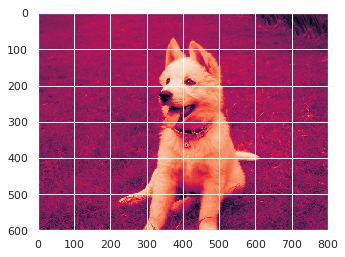


Dog image after scaling:


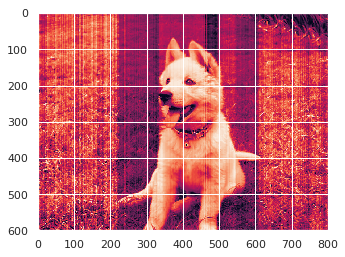

In [3]:
# Load the data
# Already in greyscale, so just take top layer which is same as other two
dog_image_data = plt.imread('data/Kintamani_dog_white_gs.jpeg')[:,:,0]
print(f"Shape of dog data = {dog_image_data.shape}")

# Show original image
print()
print("Dog image before scaling:")
dogplot = plt.imshow(dog_image_data)
plt.show()

# Scale data between (-.5, .5)
scaler = MinMaxScaler(feature_range=(-.5,.5)).fit(dog_image_data.astype(np.float64))
dog_image_data_scaled = scaler.transform(dog_image_data.astype(np.float64))

# Show scaled image
print()
print("Dog image after scaling:")
dogplot = plt.imshow(dog_image_data_scaled)
plt.show()

## Solution 1.3.2

In [4]:
# Define 3x3 filter for Edge Detection
edge_det_filter = np.array([[1,0,-1],
                            [0,0,0],
                            [-1,0,1]
                           ])

# Define 3x3 filter for Normal Box Blur
box_blur_filter = np.array([[1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9]
                           ])

# Define 3x3 filter for Sharpening
sharpen_filter = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]
                          ])

# Apply filters
dog_edge = convolve2d(dog_image_data_scaled, edge_det_filter, mode="same")
dog_box = convolve2d(dog_image_data_scaled, box_blur_filter, mode="same")
dog_sharp = convolve2d(dog_image_data_scaled, sharpen_filter, mode="same")

## Solution 1.3.3

In [5]:
# Clip the data
dog_edge_clipped = np.clip(dog_edge, a_min=0, a_max=None)
dog_box_clipped = np.clip(dog_box, a_min=0, a_max=None)
dog_sharp_clipped = np.clip(dog_sharp, a_min=0, a_max=None)

## Solution 1.3.4


Dog image edges:


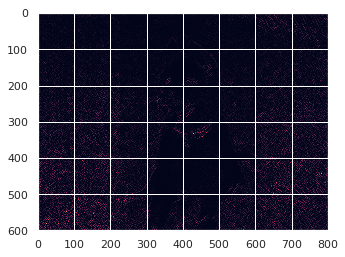


Dog image box blur:


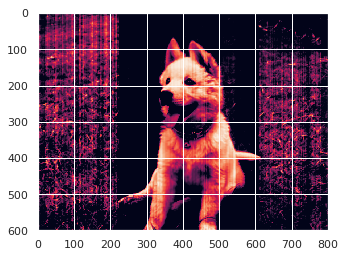


Dog image sharpened:


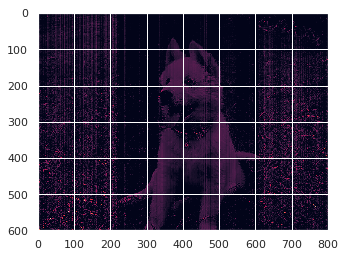

In [6]:
# Show the images
print()
print("Dog image edges:")
dogplot = plt.imshow(dog_edge_clipped)
plt.show()

print()
print("Dog image box blur:")
dogplot = plt.imshow(dog_box_clipped)
plt.show()

print()
print("Dog image sharpened:")
dogplot = plt.imshow(dog_sharp_clipped)
plt.show()

## Solution 1.3.5

### STUDENT COMMENTARY:

Including the same filters in additional convolutional layers would magnify the effect of each filter, making its effect more pronounced.

<div class='exercise'><b> Question 2: Building a Basic CNN Model [33.33333pts] </b></div>

In this question, you will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.


<span class='sub-q'> **2.1 Loading CIFAR-1O and Constructing the Model. **</span>

Load CIFAR-10 and use a combination of the [following layers](https://keras.io/layers/convolutional/): Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order) to build your model.
You may use an existing architecture like AlexNet or VGG16, or create one of your own design. However, you should write your own layers and not use a pre-written implementation.

Convolutional neural networks are very computationally intensive. We highly recommend that you train your model on a system using GPUs. On CPUs, this training can take up to several hours. On GPUs, it can be done within minutes.

You can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc.  For each generated model, keep track of the total number of parameters.

**2.1.1.** Report the total number of parameters in your model.

**2.1.2.** How does the number of total parameters change (linearly, exponentially) as the number of filters per layer increases?

**2.1.3.** Generate a plot showing the relationship in 2.1.2 and explain what you see.



<span class='sub-q'> **2.2 Choosing a Model, Training and Evaluating It. **</span>

**2.2.1.** Choose a model from 2.1 and train it. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs.  Your validation accuracy should exceed 70%. Training for 10 epochs on a CPU should take about 30-60 minutes.

**2.2.2.** Plot the loss and validation accuracy for your chosen architecture.

<span class='sub-q'>**2.3 Using Feature Maps to Visualize the Model.**</span>

We would gain an intution into how our model is processing the inputs in two ways.  First we'll ask you to use feature maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_feature_maps` to aid in extracting weights from layers in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case).

**2.3.1.** For a given input image, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid.  Make sure to plot (and clearly label) your original input image as well.

**2.3.2.** For the same input image generate and plot a saliency map to show the pixels in the image most pertinent to classification.  While you're welcome to generate the saliency map by hand, we highly recommend that you install and use [keras-vis](https://github.com/raghakot/keras-vis) and let it handle the generation.

**Hints:**

- If you assign a name to your last layer using the `name` parameter in the `Dense` layer, you'll be able to use the `find_layer_idx` function provided by keras-vis via `vis.utils.utils`
- As the keras-vis docs state: "To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph."
- If your model is stored in a variable `model` then the following code will switch the softmax activation.

```
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
```

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

*Some imports that will come in handy if you use keras-vis to implement saliency maps*

In [8]:

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

## Solution 2.1.1

### STUDENT CITE:

We read this paper to gain insights into the architecture features of VGG-16, some of which were incorporated into the model architecture below:  https://www.researchgate.net/figure/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained_fig2_319952138

In [9]:
# Create models for different number of filters
num_filters = [32, 64, 128, 256]

# Save each model in dictionary 
# key=number of filters
# value=model
dog_cnn_models = {}

# Initialize list to keep track of number of params
param_count = []

for num_filter in num_filters:
    
    dog_cnn_models[num_filter] = Sequential()
    
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu', 
                                          input_shape=(32, 32, 3)))
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(MaxPooling2D((4,4)))
    
    
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(MaxPooling2D((2,2)))
    
    
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(Conv2D(num_filter, (3, 3),
                                          strides=(1,1),
                                          padding="same", 
                                          activation='relu'))
    dog_cnn_models[num_filter].add(MaxPooling2D((2,2)))

    dog_cnn_models[num_filter].add(Dropout(.5))
    
    dog_cnn_models[num_filter].add(Flatten())
    
    dog_cnn_models[num_filter].add(Dense(512, activation='relu'))

    dog_cnn_models[num_filter].add(Dropout(.5))

    dog_cnn_models[num_filter].add(Dense(256, activation='relu'))

    dog_cnn_models[num_filter].add(Dense(10, activation='softmax', name=f"last_dense_{num_filter}"))
    
    dog_cnn_models[num_filter].summary()
    
    # Add total number of params to list
    param_count.append(dog_cnn_models[num_filter].count_params())
    
param_count_df = pd.DataFrame({"n_filter": num_filters, "n_params": param_count})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          9248      
__________

In [10]:
# Display number of parameters
param_count_df

,n_filter,n_params
0,32,256330
1,64,488842
2,128,1285642
3,256,4206346


## Solution 2.1.2

### STUDENT COMMENTARY:

- Each convoluational layer adds parameters

- For each convoluational layer, the number of parameters added is computed as follows:
    - **Factor 1:**  (3x3)=9, filter size
    - **Factor 2:**  Number of inputs (either 3, for first CnvLayer, or the number of filters/outputs from previous layer)
    - **Factor 3:**  Number of filters in the current convolutional layer
    - **Number of Parameters** = (Factor 1) x (Factor 2) x (Factor 3) + Number of Filters in Current Layer
    
- In the model we used, there are several places where two convolutional layers are adjacent to each other, thus the parameters for the second of each pair is $n^2$, where $n$ is number of filters (e.g., 32, 64, 128 or 256). 

- Thus, the term that dominates the summation of parameters from each layer is the number of parameters associated with the second convoluational layer in any pair.  Here is the number of parameters for that layer when num_filters is 256:
    - **Factor 1:**  (3x3)=9, filter size
    - **Factor 2:**  Number of inputs = number of filters from previous layer (i.e., 256 in the max filter case)
    - **Factor 3:**  Number of filters in the current convolutional layer (i.e., 256 in the max filter case)
    - **Number of Parameters** = 9 x 256 x 256 + 256 = 590,080
    
- Thus, the total number of parameters grow as the number of filters $n$ gets very large as $n^2$ grows. 

## Solution 2.1.3

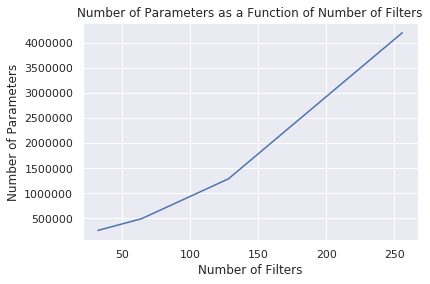

In [11]:
# Plot arams vs. number of filters
fig, ax = plt.subplots()
sns.lineplot(x=num_filters, y=param_count)
plt.xlabel(f"Number of Filters")
plt.ylabel("Number of Parameters")
plt.title(f"Number of Parameters as a Function of Number of Filters");

### STUDENT COMMENTARY:

- We see in the plot the same dynamic discussed above.
- The $n^2$ appears a bit muted at these smaller levels of $n$, since there are other terms that contribute meaningfully, though essentially constant (e.g., dense layer). 

## Solution 2.2.1

In [12]:
# Load data cifar10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize 0 to 1
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255

# Convert labels to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
# Select one of previous models as model to fit
dog_cnn_model = dog_cnn_models[64]

# Compile model
dog_cnn_model.compile(optimizer="rmsprop",
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Fit the model
dog_cnn_model_history = dog_cnn_model.fit(x_train, y_train, 
                                          epochs=15, batch_size=128,
                                          validation_data=(x_test, y_test))
                  
#  Evaluate the model on the test data:
test_loss, test_acc = dog_cnn_model.evaluate(x_test, y_test)
print(f"Accuracy on test data = {test_acc}")

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 17s 341us/step - loss: 1.9899 - acc: 0.2536 - val_loss: 1.6147 - val_acc: 0.3992
Epoch 2/15
39040/50000 [======================>.......] - ETA: 3s - loss: 1.5470 - acc: 0.4311

KeyboardInterrupt: 


## Solution 2.2.2

In [ ]:
# Plot loss training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(dog_cnn_model_history.history["loss"], "red", label="Train Data")
ax.plot(dog_cnn_model_history.history["val_loss"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Loss", fontsize = 18)
ax.set_title("Loss as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot accuracy training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(dog_cnn_model_history.history["acc"], "red", label="Train Data")
ax.plot(dog_cnn_model_history.history["val_acc"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_title("Accuracy as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend();

## Solution 2.3.1

In [ ]:
# Find number of layers in current model
for i, l in enumerate(dog_cnn_model.layers):
    print(i, l)
    
# Specify layer to inspect (1 is 2nd inner convolutional)
layer_inspect = 1

# Grab a sample image to inspect
sample_image = x_train[4000,:,:,:]

# Plot and label sampel image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,8))

ax.imshow(sample_image)
ax.set_title(f"Original Image to Inspect", fontsize=18)
plt.show()

# Get feature maps for sample_image and inspection layer
feature_maps = get_feature_maps(dog_cnn_model, layer_inspect, sample_image)

# Plot the first 9 feature maps
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (18,18))

for r in range(3):
    for c in range(3):
        axes[r,c].imshow(feature_maps[r*3+c])
        axes[r,c].set_title(f"Feature Map {r*3+c} for Layer {layer_inspect}")

## Solution 2.3.2



### STUDENT CITE:

This blog clarified what parameter to use filter_indices:  https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/

In [ ]:
# Get layer index of last dense layer
layer_idx = utils.find_layer_idx(dog_cnn_model, "last_dense_64")

# Swap linear for softmax in last layer of model (needed for keras-vis)
dog_cnn_model.layers[layer_idx].activation=activations.linear
dog_cnn_model = utils.apply_modifications(dog_cnn_model)

# Visualize the saliency maps
saliency_map = visualize_saliency(model=dog_cnn_model, 
                                   layer_idx=layer_idx, 
                                   seed_input=sample_image, 
                                   filter_indices=0)

# Plot and label sample image vs. saliency map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,6))

ax[0].imshow(sample_image)
ax[0].set_title(f"Original Image", fontsize = 16)
ax[1].imshow(saliency_map)
ax[1].set_title(f"Saliency Map", fontsize = 16)
plt.show();

## Gravitational Waves
Gravitational waves are a prediction of Einstein's Genaral Relativity theory.  They are ripples on the space-time, propagating at the speed of light, caused by the merging of two massive obejcts (e. g. black holes, white dwarves, pulsars) .

In [ ]:
Image('data/gravitational-waves-generated-by-binary-neutron-stars.jpg',width=1000)

### LIGO observatory
The Laser Interferometer Gravitational-Wave Observatory (LIGO) was designed for the direct detection of gravitational waves. It is made up of two identical and widely separated interferometers that look like this: 

In [ ]:
Image('data/100317_nobel-physics_inline_ligo-diagram.png', width=1000)

Image credit: NICOLLE RAGER FULLER

### Nobel Price Physics:
Rainer Weiss, Barry Barish, and Kip Thorne won the 2017 Nobel Prize in Physics for their work on GWs

In [ ]:
Image('data/Nobel-barish-thorne-weiss_edit.png', width=600)

Image credit: LIGO/Caltech/MIT

### What do Gravitation Wave signals look like?

This is the data from the first GW detection. The first row shows the time series observed, the second the expected signal from simulations, and the third the intensity of each frequency in time from the observed data. The left column corresponds to the Hanford detector in Washington, and the right column to the Livingston detector in Louisiana.  The GW was seen by both detectors, as expected for a real event.

In [ ]:
Image('data/LIGO_measurement_of_gravitational_waves.svg.png', width=1100)

Phys. Rev. Lett. 116, 061102 (2016) (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)

<div class='exercise'><b> Question 3: Building a CNN for Classification of Gravity Wave Events [33.3333 pts] </b></div>

You have built, trained, evaluated and inspected neural networks on a few common datasets such as MNIST or CIFAR10. Now it's time to try a real-world dataset. We want you to consider the problem of classifying images as either gravitational waves or non-detection events using images from two detectors, one from the LIGO Hanford and LIGO Livingston.

 You may find it helpful to gain some domain knowledge on gravitational wave detection. Browse through the information at the following links:



- https://www.ligo.caltech.edu/page/gravitational-waves 
- https://www.zooniverse.org/projects/zooniverse/gravity-spy 

Choose appropriate methods and visualizations to draw conclusions and answer the following questions.

<span class='sub-q'>**3.1 Learn about Gravitational Wave Detection. Load and Clean the Data.**</span>

**3.1.1** Why do you think it is important to have data from both detectors? How might you combine observations from the two detectors into a single observation? 

We've provided you with two files containing data in the form of numpy objects:

- 'data/GW_aug.npy' (data about Gravitational Wave events)

- 'data/ND_aug.npy' (data about non-detection events)  

**3.1.2** Load and read these data files into variables named `GW` and `ND` respectively. Visualize the differences between the two types of signals and then combine and prepare them for the NN by a) making a numerical response variable that is 1 for `GWs` and 0 for `ND` and b) splitting in `X_train`, `y_train`, `X_test`, and `y_test`. Have 20% of your data be in the test set.

**Hints**:
  - Scale and shuffle the data before you create the training and testing sets. 
    

<span class='sub-q'> **3.2 Build a CNN Model for GW detection.**</span>

Build a CNN Model to automatically classify event as a GW or an ND. Use a combination of layers such as Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order). 

Summarize your results in a short report. Explain why you chose the architecture you did, described what worked and what didn't. Also describe how did you proceeded to inspect your network as in Q2.


## Solution 3.1.1

### STUDENT COMMENTARY:

- The diagram above shows that non-GW signals from the two detectors normally cancel each other out, presumably as two random signals might cancel each other out.  GW-signals, on the other hand, must be sufficiently clear from background noise as to reinforce each other when seen from each detector.  There appears to be some "shifting" of the signal perhaps to compensate for differnt angles.
- Absent the above, picture, another intuition about the two detectors is that they would provide "jiggling" in the training data, preventing over-fitting in the machine learning algorithm.
- We combined the observations from the two detectors by simply concatenating the arrays, leaving observations from both detectors in the Neural Net as data from which the algorithm can learn (as opposed to averaging the two observations, for example).

## Solution 3.1.2

In [ ]:
# Load gravitational wave and non-detection event data
GW = np.load("data/GW_aug.npy")
ND = np.load("data/ND_aug.npy")

# H1 data:  last index = 0
# L1 data:  last index = 1
# Concatenate results from each detector
GW = np.concatenate((GW[:,:,:,0], GW[:,:,:,1]))
ND = np.concatenate((ND[:,:,:,0], ND[:,:,:,1]))
                     
# Get number of observations of GW and ND
(gw_rows, _, _) = GW.shape
(nd_rows, _, _) = ND.shape

# Create class weight to use in loss function to compensate for small class
class_weight = {0: gw_rows/nd_rows, 1:1}

# Average values of GW and ND to compare 2 "average" images
GW_avg = np.sum(a=GW, axis=0)/gw_rows
ND_avg = np.sum(a=ND, axis=0)/nd_rows

# Plot GW vs. ND average image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
ax[0].imshow(GW_avg)
ax[0].set_title(f"Average GW Image", fontsize = 16)
ax[1].imshow(ND_avg)
ax[1].set_title(f"Average ND Image", fontsize = 16)
plt.show();

# Create full datasets of X by concatenating GWs and NDs
X = np.concatenate((GW, ND), axis=0)

# Scale each image
X_scaled = X
for i in range(gw_rows+nd_rows):
    scaler = MinMaxScaler(feature_range=(0,1)).fit(X[i,:,:].astype(np.float64))
    X_scaled[i] = scaler.transform(X[i,:,:].astype(np.float64))
    
# Y is labels 1 for GW (first bunch) and 0 for ND (2nd bunch)
y = np.array(list([1]*gw_rows)+list([0]*nd_rows))

# Create shuffled index of X and Y
np.random.seed(seed=42)
idx = np.arange(gw_rows+nd_rows)
np.random.shuffle(idx)

# Split the index for train and test
split_point = int(.8*(gw_rows+nd_rows))
train_idx = idx[:split_point]
test_idx = idx[split_point:]

# Use train and test indices to great train and test data
X_train = np.expand_dims(X_scaled[train_idx,:,:], axis=3)
y_train = to_categorical(y[train_idx])

X_test = np.expand_dims(X_scaled[test_idx,:,:], axis=3)
y_test = to_categorical(y[test_idx])


## Solution 3.2

In [ ]:
# Replicate model used above for GWs (64 initial filters)
num_filter = 64

gw_cnn_model = Sequential()

gw_cnn_model.add(Conv2D(num_filter, (3, 3), strides=(1,1),
                        padding="same", activation='relu', 
                        input_shape=(39, 100, 1)))
gw_cnn_model.add(Conv2D(num_filter, (3, 3),strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(MaxPooling2D((4,4)))


gw_cnn_model.add(Conv2D(num_filter, (3, 3),strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(Conv2D(num_filter, (3, 3), strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(MaxPooling2D((2,2)))


gw_cnn_model.add(Conv2D(num_filter, (3, 3), strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(Conv2D(num_filter, (3, 3), strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(Conv2D(num_filter, (3, 3),strides=(1,1),
                        padding="same", activation='relu'))
gw_cnn_model.add(MaxPooling2D((2,2)))

gw_cnn_model.add(Dropout(.5))

gw_cnn_model.add(Flatten())

gw_cnn_model.add(Dense(512, activation='relu'))

gw_cnn_model.add(Dropout(.5))

gw_cnn_model.add(Dense(256, activation='relu'))

gw_cnn_model.add(Dense(2, activation='sigmoid', name=f"last_dense_{num_filter}"))

gw_cnn_model.summary()

In [ ]:
# Compile model
gw_cnn_model.compile(optimizer="rmsprop",
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Fit the model
gw_cnn_model_history = gw_cnn_model.fit(X_train, y_train, 
                                        epochs=15, batch_size=128,
                                        class_weight=class_weight,
                                        validation_data=(X_test, y_test))
                  
#  Evaluate the model on the test data:
test_loss, test_acc = gw_cnn_model.evaluate(X_test, y_test)
print(f"Accuracy on test data = {test_acc}")

In [ ]:
# Plot loss training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(gw_cnn_model_history.history["loss"], "red", label="Train Data")
ax.plot(gw_cnn_model_history.history["val_loss"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Loss", fontsize = 18)
ax.set_title("Loss as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend()

# Plot accuracy training vs. test
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(gw_cnn_model_history.history["acc"], "red", label="Train Data")
ax.plot(gw_cnn_model_history.history["val_acc"], "blue", label="Test Data")
ax.set_xlabel("Epoch Number", fontsize = 18)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_title("Accuracy as a Function of Epoch Number", fontsize=24)
ax.tick_params()
ax.legend();

In [ ]:
# Find number of layers in current model
for i, l in enumerate(gw_cnn_model.layers):
    print(i, l)
    
# Specify layer to inspect (1 is 2nd inner convolutional)
layer_inspect = 1

# Grab a sample image to inspect
sample_image = X_train[20,:,:,:]

#scaler = MinMaxScaler(feature_range=(-.5,.5)).fit(dog_image_data.astype(np.float64))
#dog_image_data_scaled = scaler.transform(dog_image_data.astype(np.float64))

# Make sample 3 layers deep
sample_image_3 = np.dstack((sample_image, sample_image, sample_image))

# Plot and label sample image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,8))

ax.imshow(sample_image_3)
ax.set_title(f"Original Image to Inspect", fontsize=18)
plt.show()

# Get feature maps for sample_image and inspection layer
feature_maps = get_feature_maps(gw_cnn_model, layer_inspect, sample_image)

# Plot the first 9 feature maps
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (18,8))

for r in range(3):
    for c in range(3):
        axes[r,c].imshow(feature_maps[r*3+c])
        axes[r,c].set_title(f"Feature Map {r*3+c} for Layer {layer_inspect}")

In [ ]:
# Get layer index of last dense layer
layer_idx = utils.find_layer_idx(gw_cnn_model, "last_dense_64")

# Swap linear for softmax in last layer of model (needed for keras-vis)
gw_cnn_model.layers[layer_idx].activation=activations.linear
gw_cnn_model = utils.apply_modifications(gw_cnn_model)

# Visualize the saliency maps
saliency_map = visualize_saliency(model=gw_cnn_model, 
                                  layer_idx=layer_idx, 
                                  seed_input=sample_image, 
                                  filter_indices=0)

# Plot and label sample image vs. saliency map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,6))

ax[0].imshow(sample_image_3)
ax[0].set_title(f"Original Image", fontsize = 16)
ax[1].imshow(saliency_map)
ax[1].set_title(f"Saliency Map", fontsize = 16)
plt.show();

### STUDENT COMMENTARY:

The model seemed to work, apparently selecting the correct label over 99% of the time.  

- In a nutshell, we implemented this CNN using the same basic structure as used in problem 2 as it seemed to work well there and we saw no need to change, except at the detailed levels noted below
- At a finer level of detail here are the similarities and differences (necessitated by the different data/problem):
    - Similarities
        - The layers and number of filters in each layer were the same as problem 2
        - Strides were kept at (1,1) in all instances
        - Filter sizes remained (3,3) in all instances
        - MaxPooling remained the same
        - Drop out layers remained the same
        - Dense layers remained the same
        - Activation remained relu, except for the final dense layer
    - Differences
        - Input dimension in first layer changed from (32,32,3) to (39,100,1) due to the shape of the incoming data
        - Final dense layer activiation is sigmoid rather than softmax due to problem being binary classification
        - Loss function changed from categorical crossentropy to binary crossentropy due to problem being binary classification
- We performed the same investigation of features on a sample image using get_feature_maps and visualize_saliency